In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import MultipleLocator
import itertools
import random
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from prophet import Prophet
from statsmodels.tsa.stattools import adfuller
from warnings import filterwarnings
import logging
filterwarnings('ignore')

In [ ]:
np.random.seed(42)
random.seed(42)

In [ ]:
file_path = 'data/hiv_aids_data_ukraine_2014_2024_by_oblast.xlsx'
data = pd.read_excel(file_path)
data['date'] = pd.to_datetime(data['year'].astype(str) + ' ' + data['month'], format='%Y %B')
data.head()

,year,month,oblast,hiv_new,aids_new,aids_death,date
0,2014,january,Україна,1940.0,872.0,274.0,2014-01-01
1,2014,january,АР Крим,104.0,33.0,12.0,2014-01-01
2,2014,january,Вінницька,28.0,26.0,4.0,2014-01-01
3,2014,january,Волинська,9.0,8.0,0.0,2014-01-01
4,2014,january,Дніпропетровська,239.0,156.0,76.0,2014-01-01


In [ ]:
ukraine_data = data[data['oblast'] == 'Україна'].copy()
ukraine_data.loc[:, 'date'] = pd.to_datetime(ukraine_data['date'])
ukraine_data.set_index('date', inplace=True)
ukraine_data.index = ukraine_data.index.to_period('M')
ukraine_data = ukraine_data.asfreq('M')
hiv_cases = ukraine_data['hiv_new']
relative_data = pd.read_excel('data/relative_hiv_new_ukraine.xlsx')
relative_data.loc[:, 'date'] = pd.to_datetime(relative_data['date'])
relative_data.set_index('date', inplace=True)
relative_data.index = relative_data.index.to_period('M')
relative_data = relative_data.asfreq('M')
relative_data = relative_data['relative_hiv_new']

In [21]:
relative_data.tail()

date
2024-08    2.349455
2024-09    2.330559
2024-10    2.327409
2024-11    1.980975
2024-12    2.632901
Freq: M, Name: relative_hiv_new, dtype: float64

In [22]:
def plot_time_series(data, title, xlabel="Date", ylabel="Values"):
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.plot(data.index.to_timestamp(), data.values, linestyle='-', color='tab:blue')
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.grid(linestyle='--')
    ax.xaxis.set_major_locator(mdates.YearLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    plt.tight_layout()
    plt.show()

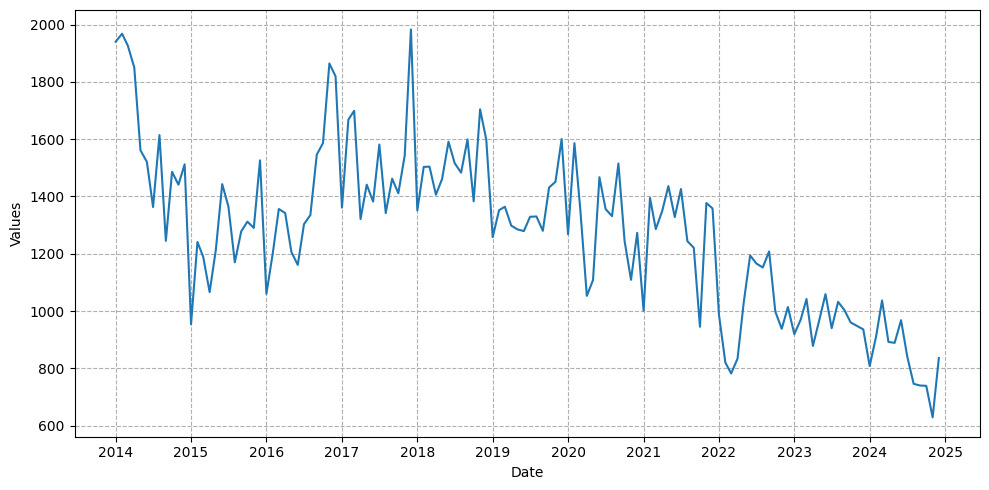

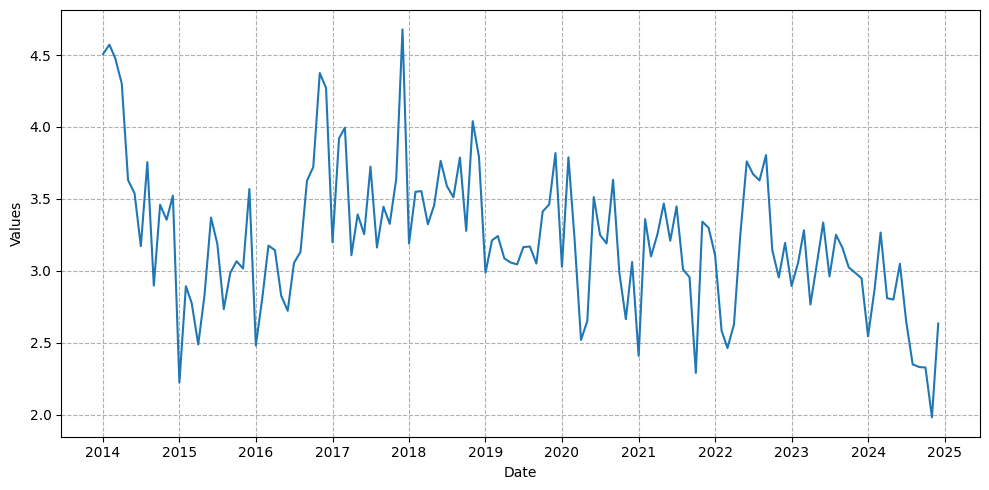

In [50]:
# plot_time_series(hiv_cases, "Monthly HIV Case Incidence in Ukraine (Absolute Numbers)")
# plot_time_series(relative_data, "Monthly HIV Case Incidence Rates in Ukraine (per 100,000 Population)")
plot_time_series(hiv_cases, None)
plot_time_series(relative_data, None)

In [24]:
relative_data

date
2014-01    4.505627
2014-02    4.572185
2014-03    4.476672
2014-04    4.301399
2014-05    3.630611
             ...   
2024-08    2.349455
2024-09    2.330559
2024-10    2.327409
2024-11    1.980975
2024-12    2.632901
Freq: M, Name: relative_hiv_new, Length: 132, dtype: float64

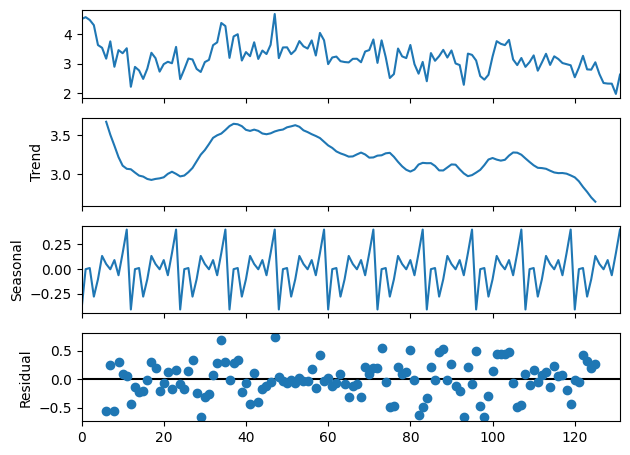

In [51]:
decomposition = seasonal_decompose(relative_data.values, model='additive', period=12)
fig = decomposition.plot()
# fig.suptitle("Seasonal decomposition of Monthly HIV Incidence Rates in Ukraine")
fig.suptitle(None)
fig.axes[0].set_title("")
plt.tight_layout()
plt.show()

In [26]:
train = relative_data[:'2021-01']
val = relative_data['2021-02':'2022-01']
test = relative_data['2022-02':]

In [ ]:
def apply_deseasoning(data, seasonality_period=12):
    """Deseason a series by subtracting monthly means."""
    seasonal_means = data.groupby(data.index.month).mean()
    data_deseasoned = []
    for idx, t in enumerate(data.index):
        month = t.month
        data_deseasoned.append(data.iloc[idx] - seasonal_means[month])
    return pd.Series(data_deseasoned, index=data.index), seasonal_means


In [27]:
def apply_detrending(data):
    """Detrend a series with a 2nd order polynomial."""
    X = np.arange(len(data)).reshape(-1, 1)
    X_poly = np.hstack([X, X**2])
    trend_model = LinearRegression().fit(X_poly, data.values)
    trend = trend_model.predict(X_poly)
    data_detrended = data.values - trend
    return pd.Series(data_detrended, index=data.index), trend_model

def apply_deseasoning(data, seasonality_period=12):
    """Deseason a series by subtracting monthly means."""
    seasonal_means = data.groupby(data.index.month).mean()
    data_deseasoned = []
    for idx, t in enumerate(data.index):
        month = t.month
        data_deseasoned.append(data.iloc[idx] - seasonal_means[month])
    return pd.Series(data_deseasoned, index=data.index), seasonal_means

def revert_deseasoning(data_deseasoned, seasonal_means):
    """Revert deseasoning by adding monthly means."""
    data_reseasoned = []
    for idx, t in enumerate(data_deseasoned.index):
        month = t.month
        data_reseasoned.append(data_deseasoned.iloc[idx] + seasonal_means[month])
    return pd.Series(data_reseasoned, index=data_deseasoned.index)

def revert_detrending(data_reseasoned, trend_model):
    """Revert detrending by adding back polynomial trend."""
    X = np.arange(len(data_reseasoned)).reshape(-1, 1)
    X_poly = np.hstack([X, X**2])
    trend = trend_model.predict(X_poly)
    data_final = data_reseasoned.values + trend
    return pd.Series(data_final, index=data_reseasoned.index)

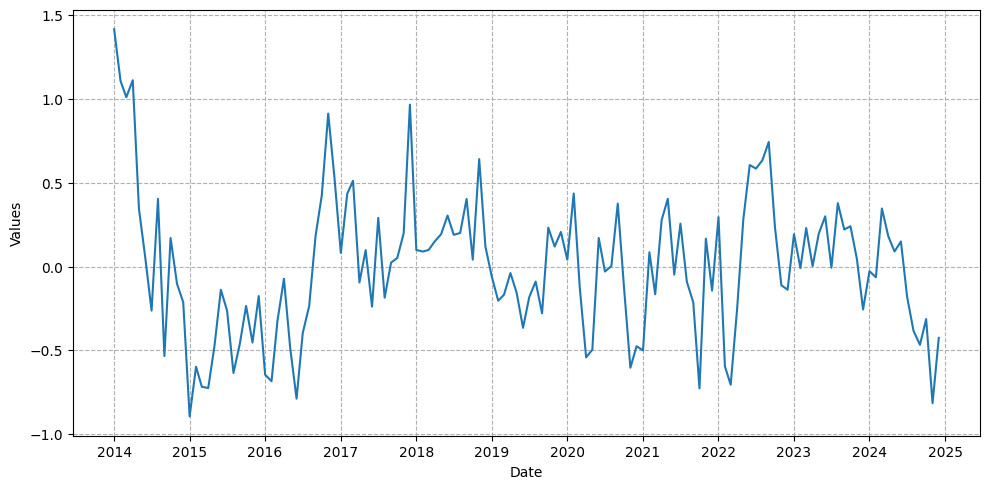

In [52]:
relative_data_detrended, trend_model = apply_detrending(relative_data)
relative_data_deseasoned, seasonal_means = apply_deseasoning(relative_data_detrended)
# plot_time_series(relative_data_deseasoned, "Monthly HIV Case Incidence Rates in Ukraine (per 100,000 Population) after detrending and deseasoning")
plot_time_series(relative_data_deseasoned, None)

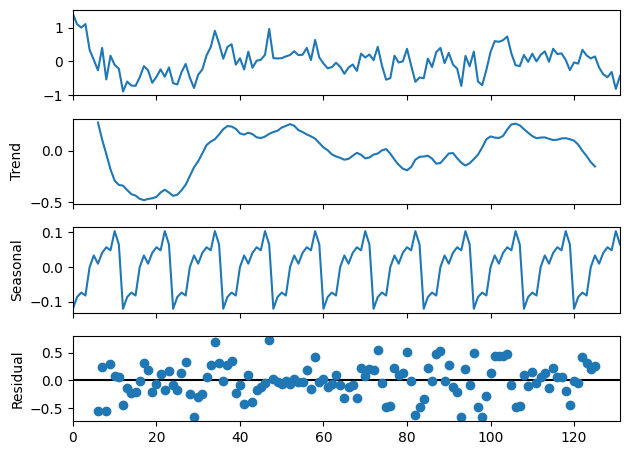

In [53]:
decomposition = seasonal_decompose(relative_data_deseasoned.values, model='additive', period=12)
fig = decomposition.plot()
# fig.suptitle("Seasonal decomposition of Monthly HIV Incidence Rates in Ukraine \n after detrending and deseasoning")
fig.suptitle(None)
fig.axes[0].set_title("")
plt.tight_layout()
plt.show()

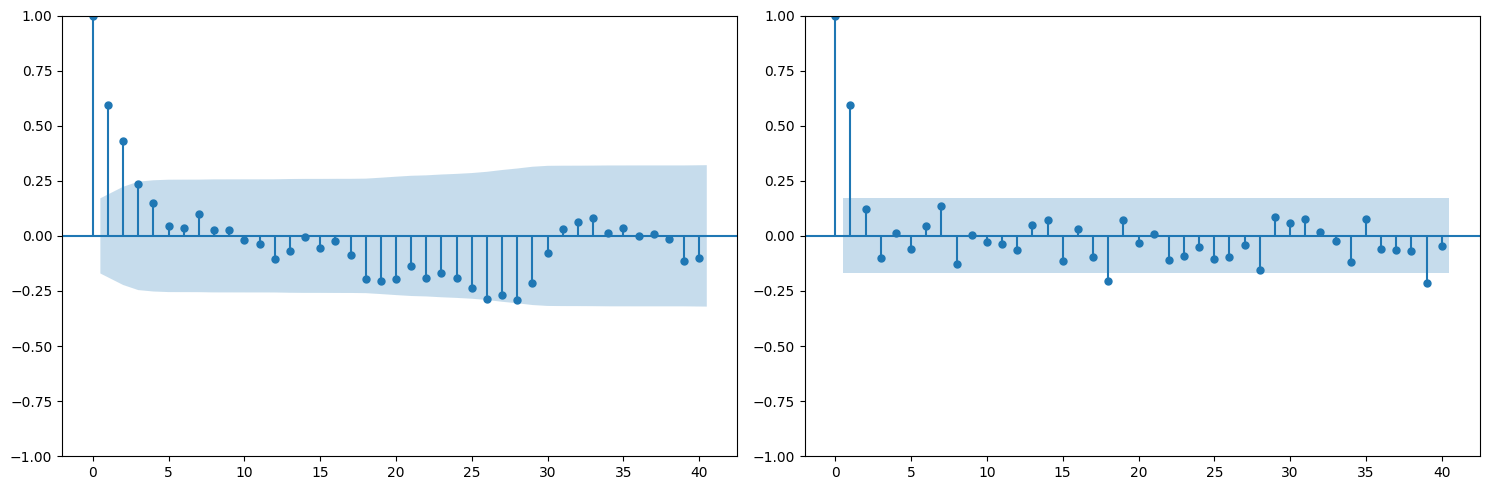

In [54]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
plot_acf(relative_data_deseasoned, ax=axes[0], lags=40)
# axes[0].set_title("ACF of Detrended and Deseasoned Data")
axes[0].set_title(None)
plot_pacf(relative_data_deseasoned, ax=axes[1], lags=40, method='ywm')
# axes[1].set_title("PACF of Detrended and Deseasoned Data")
axes[1].set_title(None)
plt.tight_layout()
plt.show()

In [31]:
adf_result = adfuller(relative_data_deseasoned.dropna())

print("ADF Statistic: %f" % adf_result[0])
print("p-value: %f" % adf_result[1])
print("Number of lags used: %d" % adf_result[2])
print("Number of observations used: %d" % adf_result[3])
print("Critical Values:")
for key, value in adf_result[4].items():
    print("\t%s: %.3f" % (key, value))

ADF Statistic: -6.076785
p-value: 0.000000
Number of lags used: 0
Number of observations used: 131
Critical Values:
	1%: -3.481
	5%: -2.884
	10%: -2.579


In [32]:
def smape(actual, forecast):
    actual = np.array(actual)
    forecast = np.array(forecast)
    return 100 / len(actual) * np.sum(2 * np.abs(forecast - actual) / (np.abs(actual) + np.abs(forecast)))

In [ ]:
p_values = [0, 1, 2]
d_values = [0, 1]
q_values = [0, 1, 2, 3]
arima_val_grid = list(itertools.product(p_values, d_values, q_values))
arima_val_grid = [x for x in arima_val_grid if x != (0,0,0)]
sarima_val_grid = [(0,0,0,0),(0,0,1,12), (1,1,1,12), (0,0,2,12)]
changepoint_scales = np.arange(0.01, 1.01, 0.01)

In [34]:
train_detrended, train_trend_model = apply_detrending(train)
train_deseasoned, train_seasonal_means = apply_deseasoning(train_detrended)

In [ ]:
results_list = []
for arima_order in arima_val_grid:
    for seasonal_order in sarima_val_grid:
        try:
            model = SARIMAX(train_deseasoned,
                            order=arima_order,
                            seasonal_order=seasonal_order,
                            enforce_stationarity=False,
                            enforce_invertibility=False)
            result = model.fit(disp=False)
            
            forecast_deseasoned = result.forecast(steps=len(val))
            forecast_reseasoned = revert_deseasoning(pd.Series(forecast_deseasoned, index=val.index), train_seasonal_means)
            forecast_final = revert_detrending(forecast_reseasoned, train_trend_model)

            smape_val = smape(val.values, forecast_final.values)
            mape_val = mean_absolute_percentage_error(val.values, forecast_final.values)
            
            results_list.append({
                'arima_order': arima_order,
                'seasonal_order': seasonal_order,
                'smape': round(smape_val / 100, 4),
                'mape': round(mape_val, 4)
            })
        
        except Exception as e:
            print(f"Failed for order={arima_order} seasonal_order={seasonal_order}. Error: {e}")
            continue
arima_results = pd.DataFrame(results_list)
arima_results.sort_values(by='smape', ascending=True, inplace=True)
arima_results.reset_index(drop=True, inplace=True)

In [ ]:
results_list = []
train_prophet = train.reset_index().rename(columns={'index':'ds', train.name:'y'})
val_prophet = val.reset_index().rename(columns={'index':'ds', val.name:'y'})

train_prophet.columns = ['ds', 'y']
val_prophet.columns = ['ds', 'y']

train_prophet['ds'] = pd.to_datetime(train_prophet['ds'].dt.to_timestamp())
val_prophet['ds'] = pd.to_datetime(val_prophet['ds'].dt.to_timestamp())

for cps in changepoint_scales:
    try:
        logging.getLogger("cmdstanpy").disabled = True
        m = Prophet(
            yearly_seasonality=True,
            weekly_seasonality=False,
            daily_seasonality=False,
            changepoint_prior_scale=cps,
            
        )
        m.fit(train_prophet)
        logging.getLogger("cmdstanpy").disabled = False

        future = m.make_future_dataframe(periods=len(val), freq='MS')
        forecast = m.predict(future)

        forecast.set_index('ds', inplace=True)
        val_index_as_datetime = val.index.to_timestamp()
        forecast_val = forecast.loc[val_index_as_datetime]['yhat']
        smape_val = smape(val.values, forecast_val.values)
        mape_val = mean_absolute_percentage_error(val.values, forecast_val.values)
        
        results_list.append({
            'model': 'Prophet',
            'changepoint_prior_scale': cps,
            'smape': round(smape_val / 100, 4),
            'mape': round(mape_val, 4)
        })
    
    except Exception as e:
        print(f"Failed Prophet changepoint_prior_scale={cps}. Error: {e}")
        continue

prophet_results = pd.DataFrame(results_list)
prophet_results.sort_values(by='smape', ascending=True, inplace=True)
prophet_results.reset_index(drop=True, inplace=True)

In [37]:
print("Top 5 ARIMA results by SMAPE on validation set:")
arima_results.head()

Top 5 ARIMA results by SMAPE on validation set:


,arima_order,seasonal_order,smape,mape
0,"(1, 1, 3)","(0, 0, 1, 12)",0.0902,0.0956
1,"(2, 1, 3)","(0, 0, 1, 12)",0.0903,0.0959
2,"(0, 1, 3)","(0, 0, 1, 12)",0.0904,0.0960
3,"(2, 1, 2)","(0, 0, 1, 12)",0.0910,0.0970
4,"(1, 1, 1)","(0, 0, 1, 12)",0.0910,0.0967


In [38]:
print("Top 5 Prophet results by SMAPE on validation set:")
prophet_results.head()

Top 5 Prophet results by SMAPE on validation set:


,model,changepoint_prior_scale,smape,mape
0,Prophet,0.01,0.0943,0.0987
1,Prophet,0.03,0.0945,0.0985
2,Prophet,0.02,0.0946,0.0985
3,Prophet,0.04,0.0946,0.0985
4,Prophet,0.05,0.0946,0.0985


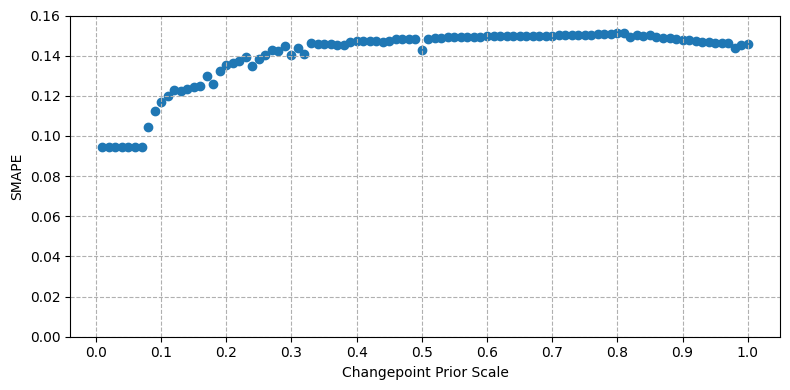

In [55]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.scatter(prophet_results['changepoint_prior_scale'], prophet_results['smape'], label='Prophet')
ax.set_xlabel('Changepoint Prior Scale')
ax.set_ylabel('SMAPE')
# ax.set_title('Prophet Changepoint Prior Scale vs SMAPE')
ax.set_title(None)
ax.set_ylim(0, 0.16)
ax.grid(linestyle='--')
ax.xaxis.set_major_locator(MultipleLocator(0.1))
plt.tight_layout()
plt.show()

In [40]:
arima_best_order = arima_results.iloc[0]['arima_order']
arima_best_seasonal_order = arima_results.iloc[0]['seasonal_order']
prophet_best_cps = prophet_results.iloc[0]['changepoint_prior_scale']

In [41]:
train_val = pd.concat([train, val])
train_val_detrended, train_val_trend_model = apply_detrending(train_val)
train_val_deseasoned, train_val_seasonal_means = apply_deseasoning(train_val_detrended)

In [42]:
model_best_arima = SARIMAX(train_val_deseasoned,
                            order=arima_best_order,
                            seasonal_order=arima_best_seasonal_order,
                            enforce_stationarity=False,
                            enforce_invertibility=False)
result_best_arima = model_best_arima.fit(disp=False)
forecast_deseasoned_best_arima = result_best_arima.forecast(steps=len(test))
forecast_reseasoned_best_arima = revert_deseasoning(pd.Series(forecast_deseasoned_best_arima, index=test.index), train_val_seasonal_means)
forecast_final_best_arima = revert_detrending(forecast_reseasoned_best_arima, train_val_trend_model)

In [43]:
model_best_prophet = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=False,
    daily_seasonality=False,
    changepoint_prior_scale=prophet_best_cps
)
train_val_prophet = train_val.reset_index().rename(columns={'index':'ds', train_val.name:'y'})
train_val_prophet.columns = ['ds', 'y']
train_val_prophet['ds'] = pd.to_datetime(train_val_prophet['ds'].dt.to_timestamp())
model_best_prophet.fit(train_val_prophet)

future_best_prophet = model_best_prophet.make_future_dataframe(periods=len(test), freq='MS')
forecast_best_prophet = model_best_prophet.predict(future_best_prophet)
forecast_best_prophet.set_index('ds', inplace=True)
forecast_best_prophet = forecast_best_prophet.loc[test.index.to_timestamp()]['yhat']
forecast_best_prophet.index = forecast_best_prophet.index.to_period('M')

16:02:56 - cmdstanpy - INFO - Chain [1] start processing
16:02:56 - cmdstanpy - INFO - Chain [1] done processing


In [ ]:
def plot_forcasted(actual, models_forecasts, title="Forecasted vs Actual"):
    """Plot actual vs forecasted values."""
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.plot(actual.index.to_timestamp(), actual.values, label='Actual', color='tab:blue')
    tab_colors = plt.get_cmap('tab10')
    for i, (model, forecast) in enumerate(models_forecasts.items()):
        ax.plot(forecast.index.to_timestamp(), forecast.values, label=model, color=tab_colors(i+1), linestyle='--')
    ax.set_title(title)
    ax.set_xlabel("Date")
    ax.set_ylabel("Values")
    ax.legend()
    ax.grid(linestyle='--')
    ax.xaxis.set_major_locator(mdates.YearLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    plt.tight_layout()
    plt.show()


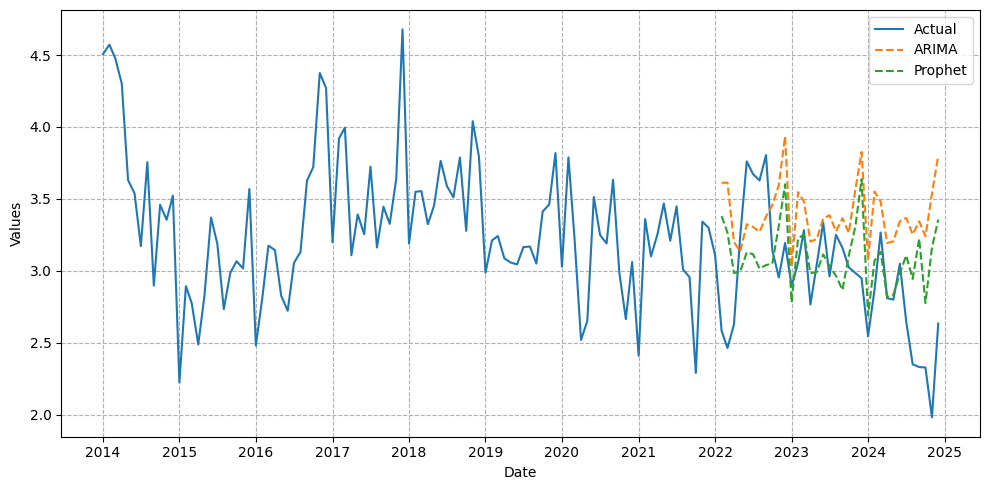

In [49]:
plot_forcasted(pd.concat([train, val, test]), {'ARIMA': forecast_final_best_arima, 'Prophet': forecast_best_prophet}, title=None)

In [ ]:
rmse_arima = root_mean_squared_error(test.values, forecast_final_best_arima.values)
rmse_prophet = root_mean_squared_error(test.values, forecast_best_prophet.values)
mape_arima = mean_absolute_percentage_error(test.values, forecast_final_best_arima.values)
mape_prophet = mean_absolute_percentage_error(test.values, forecast_best_prophet.values)
smape_arima = smape(test.values, forecast_final_best_arima.values)
smape_prophet = smape(test.values, forecast_best_prophet.values)
results_test = pd.DataFrame({
    'Model': ['ARIMA', 'Prophet'],
    'MAPE': [mape_arima, mape_prophet],
    'SMAPE': [smape_arima, smape_prophet],
    'RMSE': [rmse_arima, rmse_prophet]
})
results_test = results_test.round(4)
results_test

,Model,MAPE,SMAPE,RMSE
0,ARIMA,0.1993,17.3325,0.6434
1,Prophet,0.1352,12.5010,0.4752


In [ ]:
best_forecast_lstm = pd.read_csv('data/best_forecast_lstm.csv')
best_forecast_lstm['date'] = pd.to_datetime(best_forecast_lstm['date'])
best_forecast_lstm.set_index('date', inplace=True)
best_forecast_lstm.index = best_forecast_lstm.index.to_period('M')
best_forecast_lstm = best_forecast_lstm.asfreq('M')

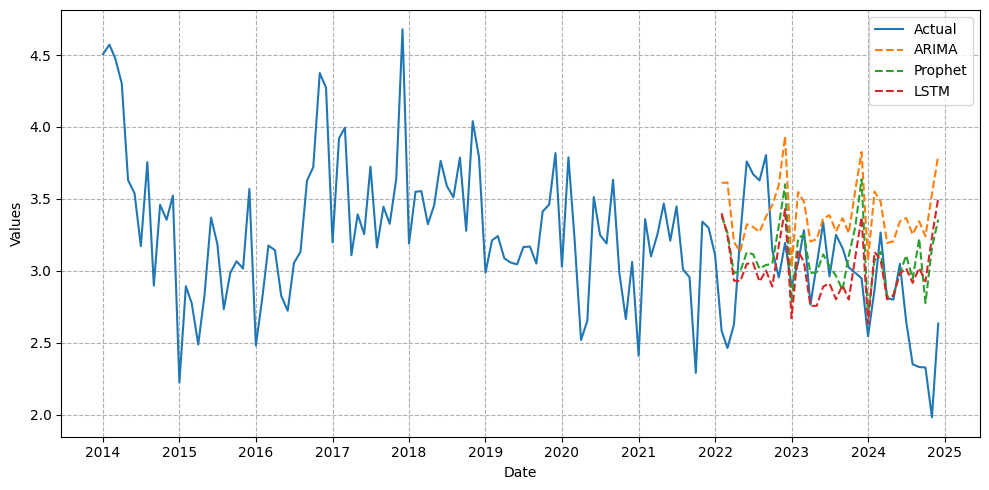

In [56]:
plot_forcasted(pd.concat([train, val, test]), {'ARIMA': forecast_final_best_arima, 'Prophet': forecast_best_prophet, 'LSTM': best_forecast_lstm}, title=None)